# Sentiment Classification & Embedding II

* Embedding Layer
* Sequence Model

# 01. What data we use?

In [64]:
import numpy as np
import pandas as pd

In [65]:
url = 'https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt'
data= pd.read_table(url, names=['label', 'reviews'])

In [66]:
data.head()

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [67]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=2021)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [68]:
train_data.shape, test_data.shape

((80000, 2), (20000, 2))

In [69]:
test_data.head()

,label,reviews
0,0,절대로 사지마세요 님들아이거 사서 열심히 설치해서 해봤는데 멀티밖에 안되는 게임이 ...
1,1,조금 해봤는데 재미있네요
2,1,제작자가 행동 하나하나를 다 꿰뚫고있음 뭔 병신짓을 해도 다 받아줘서 좋음 10/10
3,1,길이길이 남을 대작 게임.설명하려 들고 싶지 않을 정도로 완벽 그자체. 꼭 해보세요!
4,0,한글문제인건지 실행은되나 리그 시작 자체가 안됨. 돈받고 파는거면 적어도 어떤 환경...


# Q1. Tokenizing & Text to Sequences

* 상위 40000개 단어만 사용한다.

In [70]:
## 위의 한국어 전처리를 했다면 사용하지 않는다.
x_train = train_data['reviews'].astype('str').tolist()
x_test = test_data['reviews'].astype('str').tolist()

In [71]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [72]:
### Tokenizer here
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 40000
tokenizer = Tokenizer(num_words=max_words, lower=False)

In [73]:
### Tokenizer here
tokenizer.fit_on_texts(x_train)

In [74]:
%%time
# Text --> Sequence
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

CPU times: user 1.71 s, sys: 6.6 ms, total: 1.72 s
Wall time: 1.71 s


# Padding Sequence

* 문장의 최대 길이는 40으로 한다.

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
#### Pad Sequences here
max_len = 40
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre', truncating='post') # padding은 앞으로. 
x_test = pad_sequences(x_test, maxlen=max_len, padding='pre', truncating='post') # truncating은 뒤를 자르기. 두괄식이 많으므로

# 0으로 가득찬 데이터에 대한 추가 전처리

In [77]:
not0train_idx = x_train.sum(1) > 0
not0test_idx = x_test.sum(1) > 0

In [78]:
train_data = train_data.loc[not0train_idx].reset_index(drop=True)
test_data = test_data.loc[not0test_idx].reset_index(drop=True)

In [79]:
x_train = x_train[not0train_idx]
y_train = y_train[not0train_idx]

x_test = x_test[not0test_idx]
y_test = y_test[not0test_idx]

# 모델링

**모델 구조**
1. 임베딩 레이어 : 임베딩차원은 128
2. Conv1D 블록 : 필터수 64개, 윈도우 사이즈 5
3. Bidirectional layer :
    * 정방향 : LSTM, 히든스테이트 32 
    * 역방향 : LSTM, 히든스테이트 32
4. Bidirectional layer :
    * 정방향 : GRU, 히든스테이트 32
    * 역방향 : RNN, 히든스테이트 16
5. Conv1D 블록 : 필터수 32개, 윈도우 사이즈 5
6. MaxPool1D 블록 : 필터사이즈2
7. 플래튼
8. FC Layer : 노드 1024개
9. 시그모이드 레이어

In [80]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPool1D
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Model

In [81]:
#####################
## your codes here ##
#####################

# 세션 클리어
K.clear_session()

# 0. 인풋
il = Input(shape=(max_len))

# 1. 임베딩 레이어 : 임베딩차원은 128
hl = Embedding(max_words, # 사용할 총 token 개수
               128, # 한 token 당 몇차원(몇개)의 특징값으로 바꾸어 낼 것인가.
               input_length=max_len # 통일한 문장 길이
               )(il)

# 2. Conv1D 블록 : 필터수 64개, 윈도우 사이즈 5
hl = Conv1D(64, 5, padding='same', activation='swish')(hl)

# 3. Bidirectional layer :
#     * 정방향 : LSTM, 히든스테이트 32 
#     * 역방향 : LSTM, 히든스테이트 32
hl = Bidirectional(layer=LSTM(32, return_sequences=True))(hl)

# 4. Bidirectional layer :
#     * 정방향 : GRU, 히든스테이트 32
#     * 역방향 : RNN, 히든스테이트 16
forward_layer = GRU(32, return_sequences=True)
backward_layer = SimpleRNN(16, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_layer, backward_layer=backward_layer)(hl)

# 5. Conv1D 블록 : 필터수 32개, 윈도우 사이즈 5
hl = Conv1D(32, 5, padding='same', activation='swish')(hl)

# 6. MaxPool1D 블록 : 필터사이즈2
hl = MaxPool1D(2)(hl)

# 7. 플래튼
hl = Flatten()(hl)

# 8. FC Layer : 노드 1024개
hl = Dense(1024, activation='swish')(hl)

# 9. 시그모이드 레이어
ol = Dense(1, activation='sigmoid')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 128)           5120000   
                                                                 
 conv1d (Conv1D)             (None, 40, 64)            41024     
                                                                 
 bidirectional (Bidirectiona  (None, 40, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40, 48)           10704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 32)            7712  

# EarlyStopping을 이용한 학습.

1. 20%는 벨리데이션 셋.
2. 4epochs전과 비교하여 early stopping할 것.

In [82]:
#####################
## your codes here ##
#####################
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [83]:
#####################
## your codes here ##
#####################
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], batch_size=1024)

Epoch 1/100
61/61 [==============================] - 19s 194ms/step - loss: 0.6131 - accuracy: 0.6327 - val_loss: 0.4975 - val_accuracy: 0.7562
Epoch 2/100
61/61 [==============================] - 10s 172ms/step - loss: 0.3790 - accuracy: 0.8313 - val_loss: 0.4976 - val_accuracy: 0.7574
Epoch 3/100
61/61 [==============================] - 9s 141ms/step - loss: 0.2449 - accuracy: 0.8995 - val_loss: 0.6229 - val_accuracy: 0.7472
Epoch 4/100
61/61 [==============================] - 8s 136ms/step - loss: 0.1570 - accuracy: 0.9376 - val_loss: 0.8116 - val_accuracy: 0.7268
Epoch 5/100
61/61 [==============================] - 7s 116ms/step - loss: 0.1096 - accuracy: 0.9567 - val_loss: 0.9132 - val_accuracy: 0.7268
Epoch 6/100
61/61 [==============================] - 7s 122ms/step - loss: 0.0851 - accuracy: 0.9667 - val_loss: 1.0948 - val_accuracy: 0.7131
Epoch 6: early stopping


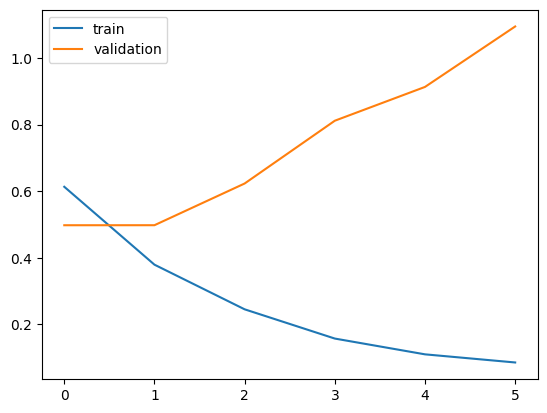

In [84]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [85]:
model.evaluate(x_test, y_test)

598/598 [==============================] - 5s 9ms/step - loss: 0.4977 - accuracy: 0.7572


[0.49767425656318665, 0.7571861743927002]

In [86]:
review_idx = 128

temp = test_data.loc[review_idx]
docu = temp['reviews']
label = 'positive' if temp['label'] ==1 else 'Negative'

print(f"문서 번호 {review_idx}")
print(label, " : ", docu)
y_pred = model.predict(x_test[review_idx:review_idx+1])
label_pred = 'positive' if y_pred[0,0] >=0.5 else 'Negative'
print(f"모델의 예측 : {label_pred},   prob = {y_pred[0,0]*100:.2f}%")

문서 번호 128
positive  :  굵고 짧은 사랑 이야기. 한글패치 잘 적용됩니다.
1/1 [==============================] - 1s 1s/step
모델의 예측 : positive,   prob = 91.99%


In [87]:
tokenizer.sequences_to_texts(x_train[0:1])

['스토리도 별루고 버그도 많고']

In [88]:
print(tokenizer.word_index['스토리'])
print(tokenizer.word_index['스토리도'])

36
199


In [89]:
print(tokenizer.index_word[36])
print(tokenizer.index_word[199])

스토리
스토리도


In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer2 = Tokenizer(num_words=5, lower=False)
temp = ['가 나 다 라 마']
tokenizer2.fit_on_texts(temp)
tokenizer2.texts_to_sequences(temp)

[[1, 2, 3, 4]]

In [91]:
tokenizer2.index_word

{1: '가', 2: '나', 3: '다', 4: '라', 5: '마'}